In [424]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights.

In [425]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [426]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. We will be try to capture all this in the model.

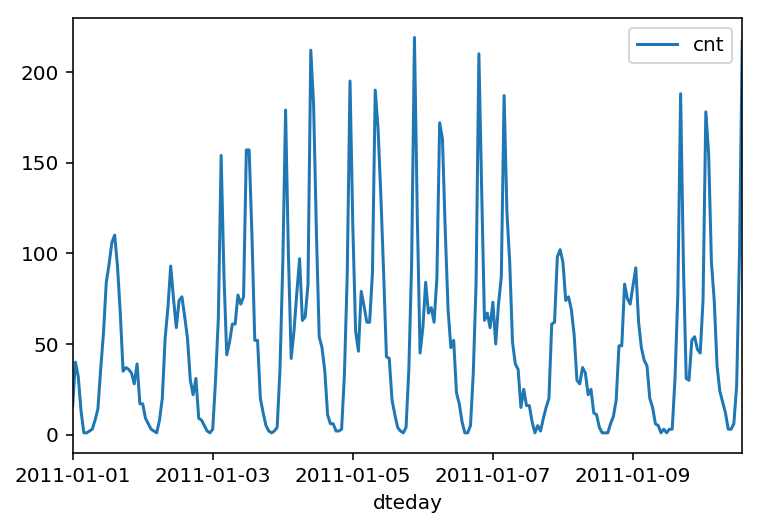

In [427]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
There are some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas using `get_dummies()`.

In [428]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

In [429]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

In [430]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [431]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Neural Network

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function.

In [464]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        

        self.activation_function = lambda x : 1/(1 + np.exp(-x))  # sigmoid activation function.
        

                    
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        
        ### Forward pass ###
        
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs) 
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs) 
        final_outputs = final_inputs 
        
       
        ### Backward pass ###
        
        
        output_errors = (targets_list-final_outputs)  
        
        hidden_errors = np.dot(output_errors,self.weights_hidden_to_output) 
        hidden_grad = hidden_outputs *(1 - hidden_outputs ) 
        
       
        self.weights_hidden_to_output += self.lr * (output_errors * hidden_outputs.T)  
        self.weights_input_to_hidden += self.lr * np.dot((hidden_errors.T * hidden_grad), inputs.T) 
        
    def run(self, inputs_list):
 
        inputs = np.array(inputs_list, ndmin=2).T
        

        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs) 
        hidden_outputs = self.activation_function(hidden_inputs) 
        
        
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = final_inputs
         
        
        return final_outputs

In [465]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [466]:
import sys


epochs = 500
learning_rate = 0.1
hidden_nodes = 3
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.8% ... Training loss: 0.133 ... Validation loss: 0.248

(0.056379224355713256, 0.5)

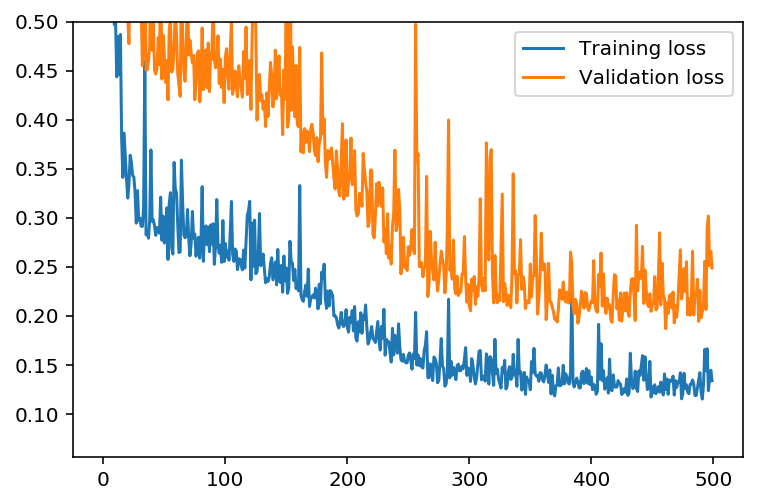

In [467]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

## Check Predictions

0.305573320174


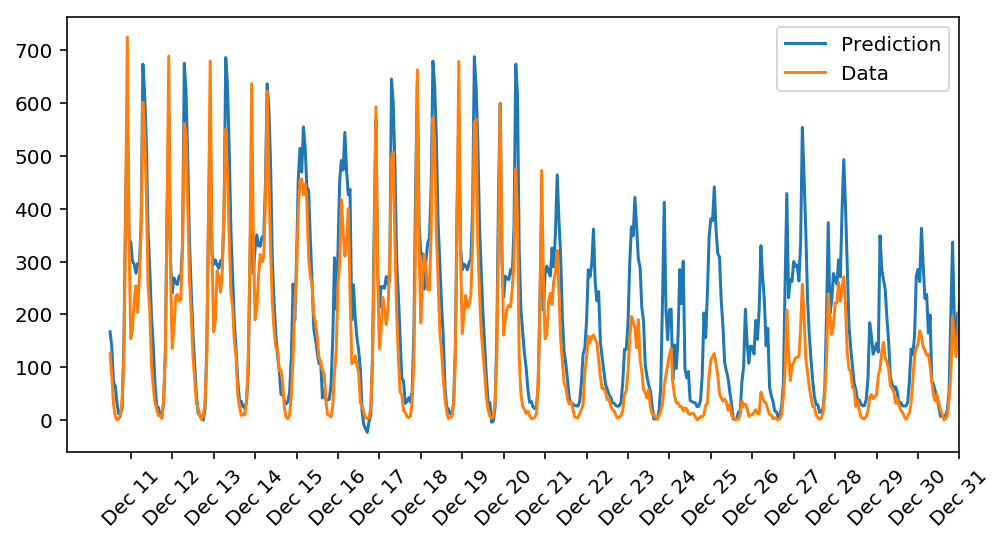

In [468]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)
print(MSE(network.run(test_features), test_targets['cnt'].values))